In [1]:
import os
import ast
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")

# 
bin_data_names = ['twitter-hate-speech-tsa', 'civil-comments', 'gibert-2018-shs', 'us-election-2020', 'cmsb-tsd']
multi_class_data_names = ['founta-2018-thas', 'davidson-thon', 'ami']
eval_data_names = bin_data_names + multi_class_data_names
check_variants = ["baseline", 
                    "sampling_modifiedRS_oversampling", "sampling_modifiedRS_undersampling", "sampling_weightedRS_combi", 
                    "augmentation_bert", 
                    "th", "wce", "fl", "wfl",
                    "augmentation_external_data_preprocessing", "augmentation_abusive_lexicon", ]

cc = False
if cc:
    eval_data_names = ['civil-comments', 'civil-comments-5k-7p5', 'civil-comments-20k', 'civil-comments-40k']
    check_variants = ['augmentation_abusive_lexicon', 
        'augmentation_external_data_preprocessing', 'baseline', 'fl',
        'sampling_modifiedRS_oversampling',
        'sampling_modifiedRS_undersampling', 'th']

data_cols = ["data_name", "num_classes", "data_type", "size", "rho", "distribution"]
variant_cols = ['variant', 'sampling_modifiedRS_rho', 'sampling_weightedRS_percentage', 'augmentation_rho', 'augmentation_percentage', 'augmentation_top_k', 'wce_alpha', 'fl_gamma', "augmentation_bert_top_k"]
metric_suffices = ['f1_macro', 'f1_per_label_0', 'f1_per_label_1', 'f1_per_label_2', 'f1_per_label_3', 'f1_per_label_4', 'accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'auprc']
metrics_cols = [f'train_{suffix}' for suffix in metric_suffices] + [f'val_{suffix}' for suffix in metric_suffices] + [f'test_{suffix}' for suffix in metric_suffices]
cols_raw = data_cols + variant_cols + ['pl_seed'] + metrics_cols + ["best_epoch"] + ['mlflow_run_id']

cols_seeds_mean = data_cols + variant_cols[:-1] + ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std'] + [metric for metric in metrics_cols if metric not in ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std']]

results_name = "results"
if cc:
    results_name += "_cc"
results_excel_path = f"results/{results_name}_all.xlsx"
cols_results = data_cols + variant_cols[:-1] + ['test_f1_macro', 'test_f1_macro_std']

In [2]:
data2distribution = {}
data2size = {}
data2rho = {}

def read_from_csv(data_name, header=0, names=None):
    if "tsv" in data_name:
        data = pd.read_csv(data_name,
                            sep='\t',
                            encoding = "utf-8",
                            engine = "python",
                            header = header,
                            names = names)
    elif "csv" in data_name:
        data = pd.read_csv(data_name,
                        encoding = "utf-8",
                        engine = "python",
                        header = header,
                        names = names)
    else:
        raise NotImplementedError("Given data file type is not supported yet.")
    return data
def get_data_info_by_data_name(data_name, label_col, category2label, train_filename, val_filename=None, test_filename=None):
    data = read_from_csv(f"./data/{data_name}/{train_filename}")
    label_counts = data[label_col].value_counts()
    if val_filename:
        val_data = read_from_csv(f"./data/{data_name}/{val_filename}")
        label_counts += val_data[label_col].value_counts()
    if test_filename:
        test_data = read_from_csv(f"./data/{data_name}/{test_filename}")
        label_counts += test_data[label_col].value_counts()
    data2size[data_name] = sum(label_counts.values)
    data2distribution[data_name] = {f"{label}_{cat}": round(label_counts[label]/data2size[data_name], 3) for cat, label in category2label.items()}
    data2rho[data_name] = round(max(label_counts.values) / min(label_counts.values), 2)

# get_data_info_by_data_name("bretschneider-th-main", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("twitter-hate-speech-tsa", "label", {"non-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-5k-7p5", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-20k", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments-40k", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
# get_data_info_by_data_name("bretschneider-th-school", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("gibert-2018-shs", "label", {"no-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("us-election-2020", "label", {"non-HOF": 0, "HOF": 1}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("cmsb-tsd", "label", {"non-sexist": 0, "sexist": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("founta-2018-thas", "label_multi", {"normal": 0, "spam": 1, "abusive": 2, "hateful": 3}, "data_clean.csv")
get_data_info_by_data_name("ami", "label_multi", {"discredit": 0, "stereotype": 1, "dominance": 2, "sexual harassment": 3, "derailing": 4}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("davidson-thon", "label_multi", {"hate speech": 0, "offensive language": 1, "neither": 2}, "data_clean.csv")

# get_data_info_by_data_name("gao-2018-fhc", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=5.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=10.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=15.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc_rho=20.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")

# get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=5.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=10.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=15.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
# get_data_info_by_data_name("waseem-and-hovy-2016_rho=20.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")


data_name_orig2display = {'twitter-hate-speech-tsa': 'Twitter-Hate-Speech', 
                            'civil-comments': 
                                    'CC-5k-rho=11.5', 
                                    # 'Civil-Comments',
                            'civil-comments-20k': 'CC-20k-rho=11.5', 
                            'civil-comments-40k': 'CC-40k-rho=11.5',
                            'civil-comments-5k-7p5': 'CC-5k-rho=7.5',
                            'gibert-2018-shs': 'Gibert-2018', 
                            'us-election-2020': 'US-Election-2020', 
                            'cmsb-tsd': 'CMSB', 
                            'waseem-and-hovy-2016': 'Waseem-and-Hovy-2016',
                            'founta-2018-thas': 'Founta-2018', 
                            'davidson-thon': 'Davidson-2017', 
                            'ami': 'AMI-2018'}

for data_name in eval_data_names:
    print(f"{data_name_orig2display[data_name]}\t{data2size[data_name]}\t{data2distribution[data_name]}\t{data2rho[data_name]}")

Twitter-Hate-Speech	31962	{'0_non-hate': 0.93, '1_hate': 0.07}	13.26
CC-5k-rho=11.5	5000	{'0_non-toxic': 0.92, '1_toxic': 0.08}	11.53
Gibert-2018	10703	{'0_no-hate': 0.888, '1_hate': 0.112}	7.95
US-Election-2020	3000	{'0_non-HOF': 0.883, '1_HOF': 0.117}	7.52
CMSB	13631	{'0_non-sexist': 0.867, '1_sexist': 0.133}	6.54
Founta-2018	46452	{'0_normal': 0.717, '1_spam': 0.163, '2_abusive': 0.085, '3_hateful': 0.035}	20.34
Davidson-2017	24783	{'0_hate speech': 0.058, '1_offensive language': 0.774, '2_neither': 0.168}	13.42
AMI-2018	2245	{'0_discredit': 0.514, '1_stereotype': 0.142, '2_dominance': 0.121, '3_sexual harassment': 0.176, '4_derailing': 0.046}	11.21


In [3]:
def get_value_by_run_id(data_dir, run_id, key):
    value = None
    for root, _, files in os.walk(data_dir + run_id):
        if key in files:
            with open(f"{root}/{key}", "r") as f:
                value = f.readlines()[-1]
                if "train" in key or "val" in key or "test" in key:
                    value = value.split()[1]
                if value == "sampling_modifiedRS": # Forgot to specify in the variant value
                    value += "_oversampling"
                if value == "sampling_weightedRS":
                    value += "_combi"
                if "tensor" in value:
                    value = "-"
                try:
                    value = ast.literal_eval(value)
                    if isinstance(value, list):
                        value = [round(v, 2) for v in value]
                        value = tuple(value)
                except (ValueError, SyntaxError):
                    pass
                break
    if value is None:
        value = "-"
        if "train" in key or "val" in key or "test" in key:
            if "per_label" in key:
                value = 0
            else:
                raise RuntimeError(f"This run log {data_dir + run_id} does not have test metrics. ")
    return value

def get_best_epoch_by_run_id(data_dir, run_id):
    ckpt_dir = f"{data_dir}{run_id}/artifacts/model_checkpoints/"
    ckpt = os.listdir(ckpt_dir)[0]
    epoch = ast.literal_eval(ckpt.split("epoch=")[1][1:2])
    return epoch

def get_log_by_data_name(data_name):
    data_runs_dir = f'/mounts/data/proj/zhangyaq/imbalanced_text_classification_logs/{data_name}/'
    run_ids = os.listdir(data_runs_dir)
    rows = []
    for run_id in run_ids:
        run_result = {col_name: get_value_by_run_id(data_runs_dir, run_id, col_name) for col_name in cols_raw[:-2]}
        run_result['best_epoch'] = get_best_epoch_by_run_id(data_runs_dir, run_id)
        run_result['mlflow_run_id'] = run_id
        rows.append(run_result)
    df = pd.DataFrame(columns=cols_raw, data=rows)
    #  - add wfl(alpha=1.0) => fl
    df.loc[(df["variant"] == "wfl") & (df["wce_alpha"] == "-"),  "variant"] = "fl" 
    #  - combine these two columns
    def fix_aug_top_k(row):
        if row["augmentation_top_k"] != "-" or row["augmentation_bert_top_k"] != "-":
            if row["augmentation_top_k"] != "-":
                return row["augmentation_top_k"]
            else:
                return row["augmentation_bert_top_k"]
        else:
            return "-"
    df["augmentation_top_k"] = df.apply(lambda row: fix_aug_top_k(row), axis=1)
    df = df.drop('augmentation_bert_top_k', axis=1)
    return df

def aggregate_results(data_name, writer):
    # Get raw mlflow logs:
    df = get_log_by_data_name(data_name)
    df.to_excel(writer, sheet_name=f"{data_name}_raw")
    assert len(df) % 3 == 0
    # Aggregate results from 3 seeds
    agg_target = {metric: 'mean' for metric in metrics_cols}
    agg_target.update({col: 'first' for col in data_cols})
    df['test_f1_macro_std'] = df.loc[:, 'test_f1_macro']
    agg_target.update({'test_f1_macro_std': 'std'})
    df_seeds_mean = df.groupby(variant_cols[:-1], as_index=False).agg(agg_target)
    #  - change metric to be 00.00
    for metric in metrics_cols + ['test_f1_macro_std']:
        df_seeds_mean[metric] = df_seeds_mean[metric].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
    def convert_str2number(x):
        if type(x) == str and x != "-":
            return ast.literal_eval(x)
        else:
            return x
    for var in variant_cols[1:-1]:
        df_seeds_mean[var] = df_seeds_mean[var].apply(lambda x: convert_str2number(x))
    df_seeds_mean.loc[:, "size"] = [data2size[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "distribution"] = [data2distribution[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "rho"] = [data2rho[data_name]] * len(df_seeds_mean)
    #  - re-order the columns
    df_seeds_mean = df_seeds_mean[cols_seeds_mean]
    if data_name == "founta-2018-thas":
        df_seeds_mean = df_seeds_mean[~((df_seeds_mean["data_name"] == data_name) & (df_seeds_mean["variant"] == "augmentation_external_data"))]
        df_seeds_mean.loc[(df_seeds_mean["data_name"] == data_name) & (df_seeds_mean["variant"] == "augmentation_external_data_oversampling"), "variant"] = "augmentation_external_data"
        df_seeds_mean = df_seeds_mean[~((df_seeds_mean["data_name"] == data_name) & (df_seeds_mean["variant"] == "augmentation_external_data_oversampling"))]
    df_seeds_mean.to_excel(writer, sheet_name=f"{data_name}_seeds-mean")
    df_seeds_mean = df_seeds_mean[df_seeds_mean["variant"].isin(check_variants)]
    df_val_f1_max = df_seeds_mean.loc[df_seeds_mean.groupby(["variant"])['val_f1_macro'].idxmax()].reset_index(drop=True)
    return df, df_seeds_mean, df_val_f1_max

In [4]:
data_names = eval_data_names

writer = pd.ExcelWriter(results_excel_path)
df_all_raw_results = pd.DataFrame(columns=cols_raw)
df_all_mean_results = pd.DataFrame(columns=cols_seeds_mean)
df_all_agg_results = pd.DataFrame(columns=cols_results)
for data_name in data_names:
    print(f"Extracting logs for {data_name} ...")
    df, df_seeds_mean, df_val_f1_max = aggregate_results(data_name, writer)
    df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
    df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
    df_all_agg_results = pd.concat([df_all_agg_results, df_val_f1_max], ignore_index=True)
df_all_raw_results.to_csv(f"results/raw_{results_name}.csv", index=False)
df_all_mean_results.to_csv(f"results/mean_{results_name}.csv", index=False)
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
df_all_agg_results.to_csv(f"results/agg_{results_name}.csv", index=False)
df_all_agg_results.to_excel(writer, sheet_name=f"best_of_all")

variants = df_all_agg_results.variant.unique()
df_table = pd.DataFrame(columns=data_names)
for variant in variants:
    for data_name in data_names:
        condition = (df_all_agg_results["variant"] == variant) & (df_all_agg_results["data_name"] == data_name)
        if len(df_all_agg_results[condition]) > 0:
            df_table.loc[variant, data_name] = f"{df_all_agg_results[condition]["test_f1_macro"].values[0]} ({df_all_agg_results[condition]["test_f1_macro_std"].values[0]})"
df_table = df_table.reindex(check_variants)

df_table.to_excel(writer, sheet_name=f"Table")
writer.close()

Extracting logs for twitter-hate-speech-tsa ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/tmp/ipykernel_44299/3563213122.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
/tmp/ipykernel_44299/3563213122.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavio

Extracting logs for civil-comments ...
Extracting logs for gibert-2018-shs ...
Extracting logs for us-election-2020 ...
Extracting logs for cmsb-tsd ...
Extracting logs for founta-2018-thas ...
Extracting logs for davidson-thon ...
Extracting logs for ami ...


In [5]:
df_table

,twitter-hate-speech-tsa,civil-comments,gibert-2018-shs,us-election-2020,cmsb-tsd,founta-2018-thas,davidson-thon,ami
baseline,87.21 (0.55),75.99 (0.46),76.89 (0.7),75.62 (1.53),84.36 (0.53),62.7 (0.91),74.7 (0.59),54.65 (2.35)
sampling_modifiedRS_oversampling,87.65 (0.28),75.85 (2.6),77.25 (0.82),76.23 (1.59),84.83 (0.41),63.98 (0.25),75.64 (0.46),55.7 (1.68)
sampling_modifiedRS_undersampling,87.16 (0.29),73.97 (2.66),75.72 (0.62),77.0 (1.73),84.33 (0.62),64.38 (1.68),76.57 (0.19),54.46 (1.45)
sampling_weightedRS_combi,87.1 (0.7),74.15 (2.78),77.21 (0.7),74.87 (2.87),84.84 (0.31),62.46 (0.5),74.94 (0.74),53.62 (1.28)
augmentation_bert,87.49 (0.52),75.88 (1.43),75.74 (1.04),74.22 (0.26),84.85 (0.5),63.37 (0.77),75.19 (0.34),54.62 (2.25)
th,86.18 (1.1),75.27 (2.12),77.11 (0.97),77.06 (2.34),84.91 (1.12),61.9 (0.35),74.33 (0.91),53.83 (0.79)
wce,87.39 (0.38),73.55 (0.54),75.62 (1.03),77.02 (0.99),84.19 (0.38),64.33 (1.36),75.48 (0.18),55.35 (3.37)
fl,88.01 (0.63),76.75 (0.91),77.45 (0.34),74.44 (2.76),84.72 (0.49),63.55 (0.5),74.74 (0.86),56.44 (0.76)
wfl,87.36 (0.67),73.45 (3.04),76.39 (0.96),74.73 (2.25),84.84 (1.18),64.22 (0.98),75.52 (0.52),55.54 (3.82)
augmentation_external_data_preprocessing,87.16 (0.45),76.77 (3.04),75.85 (0.45),NaN,84.59 (0.58),64.2 (0.82),73.71 (0.5),NaN


In [29]:
df_all_mean_results.variant.unique(), df_all_agg_results.variant.unique()

(array(['augmentation_abusive_lexicon', 'augmentation_bert',
        'augmentation_external_data_preprocessing', 'baseline', 'fl',
        'sampling_modifiedRS_oversampling',
        'sampling_modifiedRS_undersampling', 'sampling_weightedRS_combi',
        'th', 'wce', 'wfl'], dtype=object),
 array(['wfl', 'wce', 'sampling_modifiedRS_undersampling',
        'sampling_weightedRS_combi', 'th', 'augmentation_abusive_lexicon',
        'sampling_modifiedRS_oversampling', 'augmentation_bert',
        'baseline', 'fl', 'augmentation_external_data_preprocessing'],
       dtype=object))

In [33]:
df_all_agg_results = df_all_agg_results[df_all_agg_results["variant"].isin(['augmentation_abusive_lexicon', 
        'augmentation_external_data_preprocessing', 'baseline', 'fl',
        'sampling_modifiedRS_oversampling',
        'sampling_modifiedRS_undersampling', 'th'])]
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
# df_all_agg_results.variant.unique()
df_all_agg_results.to_csv(f"results/agg_{results_name}.csv", index=False)

## Plot results

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context("paper")
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Std

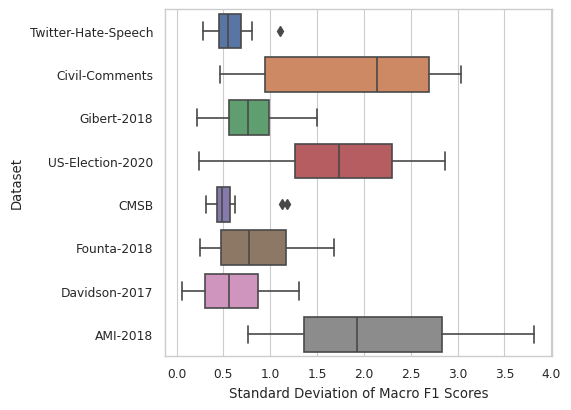

In [35]:
fig, ax = plt.subplots(figsize=(5,4.5))#
df_std = df_all_agg_results[["data_name", "test_f1_macro_std"]]
df_std = df_std.rename({"data_name":"Dataset", "test_f1_macro_std":"Standard Deviation of Macro F1 Scores"}, axis=1)
df_std["Dataset"] = df_std['Dataset'].map(data_name_orig2display)
data_order = [data_name_orig2display[data_name] for data_name in data_names]
sns.boxplot(x="Standard Deviation of Macro F1 Scores", y="Dataset", data=df_std, order=data_order)
# ax.set_xticks([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
ax.figure.savefig('results/all_std_distribution.svg', dpi=600, bbox_inches="tight")

### Random Oversampling

#### Overfitting

In [22]:
# rho_name = "augmentation_rho"
# data_clear_overfitting = ["civil-comments", "davidson-thon"]
# which_data_to_check = (df_all_mean_results["variant"].isin(["baseline", "augmentation_external_data"])) & (df_all_mean_results["data_name"].isin(data_clear_overfitting))
# df_overfitting = df_all_mean_results[which_data_to_check][["data_name", rho_name, "train_f1_macro", "val_f1_macro", "test_f1_macro"]]
# def compute_deviation_to_baseline(row, split):
#     baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting[rho_name] == "-")
#     baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
#     return row[f"{split}_f1_macro"] - baseline_value
# for split in ["train", "val", "test"]:
#     df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
# df_overfitting = df_overfitting[df_overfitting[rho_name] != "-"]
# df_overfitting = df_overfitting[[rho_name, "data_name", "train_f1_macro_delta", "val_f1_macro_delta", "test_f1_macro_delta"]]
# df_overfitting

,augmentation_rho,data_name,train_f1_macro_delta,val_f1_macro_delta,test_f1_macro_delta
137,1.0,civil-comments,1.18,0.02,1.05
138,2.0,civil-comments,1.09,1.31,0.45
139,3.0,civil-comments,0.92,0.39,0.54
140,5.0,civil-comments,0.27,0.86,-0.18
141,7.5,civil-comments,0.67,0.15,-0.83
632,1.0,davidson-thon,5.00,-1.28,-1.63
633,2.0,davidson-thon,4.69,-1.64,-2.07
634,3.0,davidson-thon,4.72,-1.03,-1.17
635,5.0,davidson-thon,2.84,0.26,-0.53
636,7.5,davidson-thon,2.49,-1.63,-1.31


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


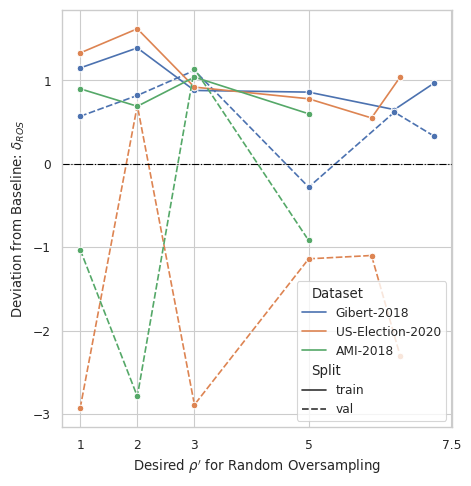

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
data_clear_overfitting = ["twitter-hate-speech-tsa", "civil-comments", "cmsb-tsd", "founta-2018-thas", "davidson-thon", ]
data_no_overfitting = ["gibert-2018-shs", "us-election-2020", "ami"]

fig_name = "no_overfitting"
data = data_no_overfitting
rho_ticks = [1,2,3,5,7.5]

# fig_name = "clear_overfitting"
# data = data_clear_overfitting
# rho_ticks = [1,2,3,5,7.5,10,15]

which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])) 
                        & (df_all_mean_results["data_name"].isin(data))
                        )
rho_name = "sampling_modifiedRS_rho"
splits = ["train", "val"]
df_overfitting = df_all_mean_results[which_data_to_check][["data_name", rho_name]+[f"{split}_f1_macro" for split in splits]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting[rho_name] == "-")
    baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
for split in splits:
    df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
df_overfitting = df_overfitting[df_overfitting[rho_name] != "-"]
df_overfitting = df_overfitting[["data_name", rho_name]+[f"{split}_f1_macro_delta" for split in splits]]

df_overfitting_expanded = pd.DataFrame(columns=[rho_name, "data_name", "split", "f1_delta"])
rhos_unique = df_overfitting[rho_name].unique().tolist()[:-1]
data_names_unique = df_overfitting.data_name.unique().tolist()
data_names_list = []
for data_name in data_names_unique:
    data_names_list += [data_name_orig2display[data_name]] * len(splits) * len(rhos_unique)
df_overfitting_expanded["data_name"] = data_names_list
rhos_list = []
for rho in rhos_unique:
    rhos_list += [rho] * len(splits)
df_overfitting_expanded[rho_name] = rhos_list * len(data_names_unique)
df_overfitting_expanded["split"] = splits * len(rhos_unique) * len(data_names_unique)
for data_name in data_names_unique:
    for split in splits:
        for rho in rhos_unique:
            where_to_assign = ((df_overfitting_expanded["data_name"] == data_name_orig2display[data_name]) 
                                & (df_overfitting_expanded["split"] == split)
                                & (df_overfitting_expanded[rho_name] == rho))
            value_from_where = ((df_overfitting["data_name"] == data_name)
                                & (df_overfitting[rho_name] == rho))
            if len(df_overfitting[value_from_where]) > 0:
                value = df_overfitting.loc[value_from_where, f"{split}_f1_macro_delta"].values[0]
                df_overfitting_expanded.loc[where_to_assign, "f1_delta"] = value
df_overfitting_expanded = df_overfitting_expanded.rename({"data_name":"Dataset", "split":"Split"}, axis=1)

fig, ax = plt.subplots(figsize=(4.8,4.95))
sns.lineplot(x=rho_name, y="f1_delta", data=df_overfitting_expanded, 
                hue="Dataset", style="Split", marker="o", ax=ax)#
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r'Deviation from Baseline: $\delta_{ROS}$')
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig(f'results/ROS_{fig_name}.svg', dpi=600, bbox_inches="tight")

#### Changes with rho

/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


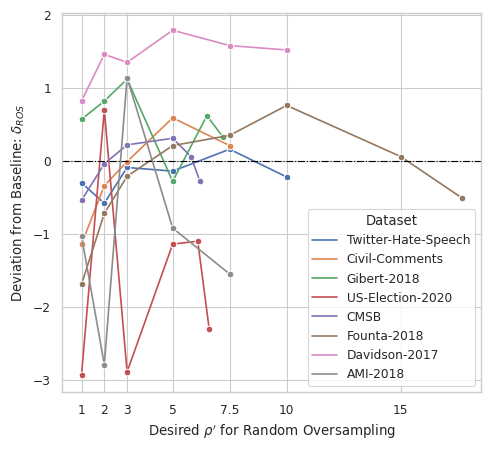

In [37]:
rho_name = "sampling_modifiedRS_rho"
data_clear_ros = ["founta-2018-thas"]
which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])) 
                        # & ~(df_all_mean_results["data_name"].isin(data_clear_ros))
                        )
df_ros = df_all_mean_results[which_data_to_check][["data_name", rho_name, "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_ros["data_name"] == row["data_name"]) & (df_ros[rho_name] == "-")
    baseline_value = df_ros.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_ros["val_f1_macro_delta"] = df_ros.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_ros = df_ros[df_ros[rho_name] != "-"]
df_ros = df_ros[[rho_name, "data_name", "val_f1_macro_delta"]]
df_ros = df_ros.rename({"data_name":"Dataset"}, axis=1)
df_ros["Dataset"] = df_ros['Dataset'].map(data_name_orig2display)
rhos_unique = df_ros.sampling_modifiedRS_rho.unique().tolist()

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4.6)) # 
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_ros, 
                hue="Dataset", marker="o", ax=ax)#
rho_ticks = [1,2,3,5,7.5,10,15]
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r"Deviation from Baseline: $\delta_{ROS}$")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/ROS_trend.svg', dpi=600, bbox_inches="tight")

findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
findfont: Font family 'Times Roman' not found.
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

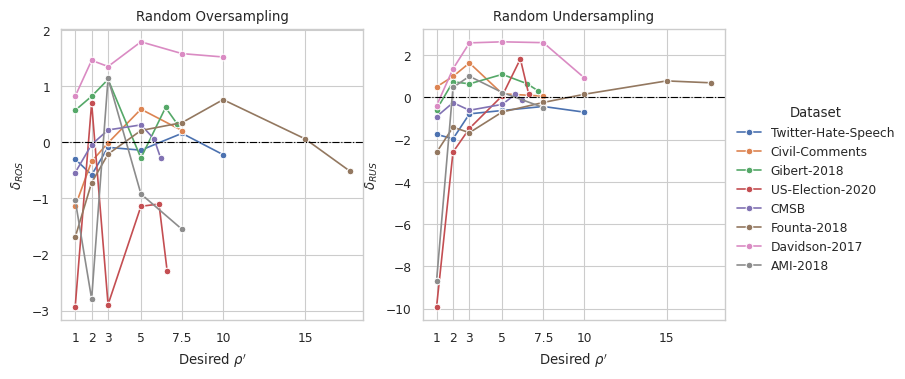

In [90]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.family':'Times Roman',
      'font.size' : 15}
plt.rcParams.update(rc)
g = sns.FacetGrid(df_ros_rus, col="variant", hue="Dataset", sharey=False, height=4, aspect=.95)
g.map(sns.lineplot, "sampling_modifiedRS_rho", "val_f1_macro_delta", marker="o")
g.add_legend()
rho_ticks = [1,2,3,5,7.5,10,15]
axs = list(g.axes_dict.values())
axs[0].set_title('Random Oversampling')
axs[0].set_ylabel(r"$\delta_{ROS}$")
# axs[0].set_yticks([-3,-2,-1,0,1,2], labels=[-3,-2,-1,0,1,2])
axs[1].set_title('Random Undersampling')
axs[1].set_ylabel(r"$\delta_{RUS}$")
# rus_yticks = list(range(-10, 2, 2))
# axs[1].set_yticks(rus_yticks, labels=rus_yticks)
for ax in axs:
    ax.set_xticks(rho_ticks, labels=rho_ticks)
    ax.set_xlabel(r"$\rho^{\prime}$")
    ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

In [80]:
rho_name = "sampling_modifiedRS_rho"
which_data_to_check = ((df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "sampling_modifiedRS_undersampling"])) )
df_ros_rus = df_all_mean_results[which_data_to_check][["data_name", "variant", rho_name, "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_ros_rus["val_f1_macro_delta"] = df_ros_rus.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_ros_rus = df_ros_rus[[rho_name, "variant", "data_name", "val_f1_macro_delta"]]
df_ros_rus = df_ros_rus.rename({"data_name":"Dataset"}, axis=1)
df_ros_rus["Dataset"] = df_ros_rus['Dataset'].map(data_name_orig2display)
df_ros_rus

,sampling_modifiedRS_rho,variant,Dataset,val_f1_macro_delta
45,1.0,sampling_modifiedRS_oversampling,Twitter-Hate-Speech,-0.30
46,2.0,sampling_modifiedRS_oversampling,Twitter-Hate-Speech,-0.58
47,3.0,sampling_modifiedRS_oversampling,Twitter-Hate-Speech,-0.09
48,5.0,sampling_modifiedRS_oversampling,Twitter-Hate-Speech,-0.14
49,7.5,sampling_modifiedRS_oversampling,Twitter-Hate-Speech,0.16
...,...,...,...,...
760,1.0,sampling_modifiedRS_undersampling,AMI-2018,-8.68
761,2.0,sampling_modifiedRS_undersampling,AMI-2018,0.47
762,3.0,sampling_modifiedRS_undersampling,AMI-2018,1.00
763,5.0,sampling_modifiedRS_undersampling,AMI-2018,0.23


## Random Undersampling

/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


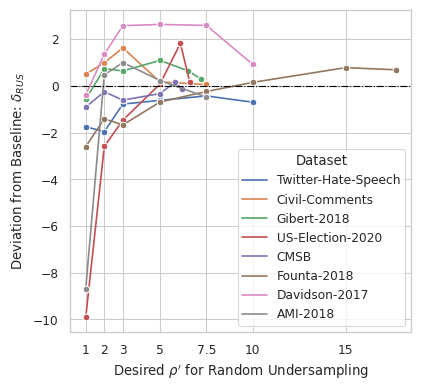

In [57]:
data_noclear_lossinfo_imbalance = ["founta-2018-thas"]
which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_undersampling"]))
                        # & (~df_all_mean_results["data_name"].isin(data_noclear_lossinfo_imbalance))
                        )
df_rus = df_all_mean_results[which_data_to_check][["data_name", "sampling_modifiedRS_rho", "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_rus["data_name"] == row["data_name"]) & (df_rus["sampling_modifiedRS_rho"] == "-")
    baseline_value = df_rus.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_rus["val_f1_macro_delta"] = df_rus.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_rus = df_rus[df_rus["sampling_modifiedRS_rho"] != "-"]
df_rus = df_rus[["sampling_modifiedRS_rho", "data_name", "val_f1_macro_delta"]]
df_rus = df_rus.rename({"data_name":"Dataset"}, axis=1)
df_rus["Dataset"] = df_rus['Dataset'].map(data_name_orig2display)
rhos_unique = df_rus.sampling_modifiedRS_rho.unique().tolist()

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.3,4))
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_rus, 
                hue="Dataset", marker="o", ax=ax)#
rho_ticks = [1,2,3,5,7.5,10,15]
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Desired $\rho^{\prime}$ for Random Undersampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r"Deviation from Baseline: $\delta_{RUS}$")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/RUS_trend.svg', dpi=600, bbox_inches="tight")

/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-pack

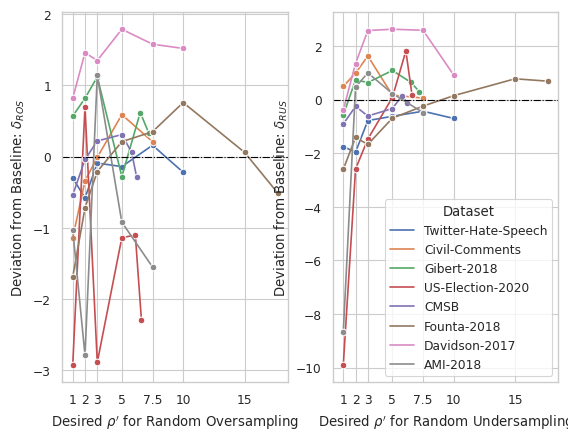

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2)
rho_ticks = [1,2,3,5,7.5,10,15]
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_ros, hue="Dataset", marker="o", ax=axs[0])#
axs[0].get_legend().remove()
axs[0].set_xticks(rho_ticks, labels=rho_ticks)
axs[0].set_xlabel(r"Desired $\rho^{\prime}$ for Random Oversampling")
axs[0].set_ylabel(r"Deviation from Baseline: $\delta_{ROS}$")
sns.lineplot(x="sampling_modifiedRS_rho", y="val_f1_macro_delta", data=df_rus, hue="Dataset", marker="o", ax=axs[1])#
# axs[1].get_legend().remove()
axs[1].set_xticks(rho_ticks, labels=rho_ticks)
axs[1].set_xlabel(r"Desired $\rho^{\prime}$ for Random Undersampling")
axs[1].set_ylabel(r"Deviation from Baseline: $\delta_{RUS}$")
# sns.lineplot(x="fl_gamma", y="val_f1_macro_delta", data=df_mean_fl, hue="Dataset", marker="o", ax=axs[2])
# gamma_ticks = df_mean_fl.fl_gamma.unique().tolist()
# axs[2].set_xticks(gamma_ticks, labels=gamma_ticks, rotation=90)
# axs[2].set_xlabel(r"$\gamma$ in Focal Loss")
# axs[2].set_ylabel(r"Deviation from Baseline: $\delta_{FL}$")

for ax in axs:
    ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")

# fig.tight_layout()
fig.savefig('results/all_trends.svg', dpi=600, bbox_inches="tight")

## Combi RS

/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


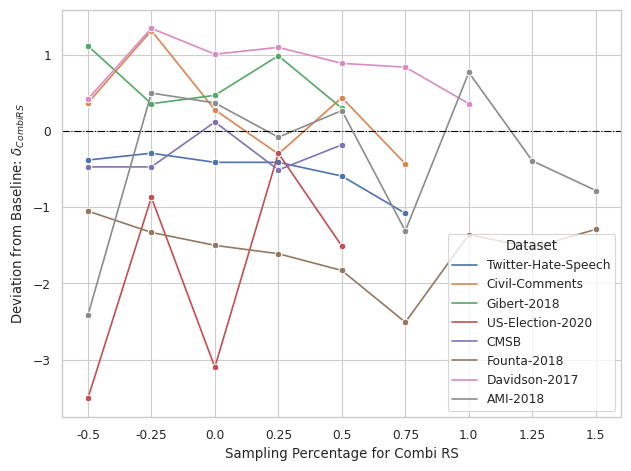

In [36]:
# data_noclear_lossinfo_imbalance = ["founta-2018-thas"]
which_data_to_check = ((df_all_mean_results["variant"].isin(["baseline", "sampling_weightedRS_combi"]))
                        # & (~df_all_mean_results["data_name"].isin(data_noclear_lossinfo_imbalance))
                        )
rho_name = "sampling_weightedRS_percentage"
df_rus = df_all_mean_results[which_data_to_check][["data_name", rho_name, "val_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_rus["data_name"] == row["data_name"]) & (df_rus[rho_name] == "-")
    baseline_value = df_rus.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
df_rus["val_f1_macro_delta"] = df_rus.apply(lambda row: compute_deviation_to_baseline(row, "val"), axis=1)
df_rus = df_rus[df_rus[rho_name] != "-"]
df_rus = df_rus[[rho_name, "data_name", "val_f1_macro", "val_f1_macro_delta"]]
df_rus = df_rus.rename({"data_name":"Dataset"}, axis=1)
df_rus["Dataset"] = df_rus['Dataset'].map(data_name_orig2display)
rhos_unique = df_rus[rho_name].unique().tolist()

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()#figsize=(4.3,4.4)
sns.lineplot(x=rho_name, y="val_f1_macro_delta", data=df_rus, 
                hue="Dataset", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel(r"Sampling Percentage for Combi RS")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel(r"Deviation from Baseline: $\delta_{Combi RS}$")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('results/Combi-RS_trend.svg', dpi=600, bbox_inches="tight")

## Compare ROS, Augmentation

In [119]:
variant_to_check = ["baseline", "sampling_modifiedRS_oversampling", "augmentation_bert", "augmentation_abusive_lexicon", "augmentation_external_data"]
which_data_to_check = (df_all_agg_results["variant"].isin(variant_to_check))
metrics_to_check = ["test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]
df_mean_ros_aug = df_all_agg_results[which_data_to_check][["data_name", "variant", ] + metrics_to_check]
df_mean_ros_aug

,data_name,variant,test_f1_macro,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
4,ami,augmentation_bert,54.62,66.38,82.02,42.11,55.01,27.60
5,ami,baseline,54.65,66.18,85.77,43.97,53.59,23.75
8,ami,augmentation_abusive_lexicon,55.61,66.66,85.02,44.88,55.60,25.88
9,ami,sampling_modifiedRS_oversampling,55.70,65.73,84.46,45.08,55.18,28.04
17,civil-comments,augmentation_abusive_lexicon,75.67,95.84,55.50,0.00,0.00,0.00
18,civil-comments,sampling_modifiedRS_oversampling,75.85,96.28,55.42,0.00,0.00,0.00
19,civil-comments,augmentation_bert,75.88,96.08,55.68,0.00,0.00,0.00
20,civil-comments,baseline,75.99,95.94,56.04,0.00,0.00,0.00
21,civil-comments,augmentation_external_data,76.44,96.41,56.48,0.00,0.00,0.00
25,cmsb-tsd,baseline,84.36,95.74,72.98,0.00,0.00,0.00


In [120]:
df_mean_ros_aug_by_data = pd.DataFrame(columns=["variant"] + sum([[f"{data_name}_{metric}" for metric in metrics_to_check] for data_name in data_names], []))
df_mean_ros_aug_by_data["variant"] = variant_to_check
for data_name in data_names:
    for variant in variant_to_check:
        conditions = (df_mean_ros_aug["data_name"] == data_name) & (df_mean_ros_aug["variant"] == variant)
        if len(df_mean_ros_aug[conditions]) > 0:
            value = df_mean_ros_aug.loc[conditions, "test_f1_macro"].values[0]
            df_mean_ros_aug_by_data.loc[df_mean_ros_aug_by_data["variant"] == variant, f"{data_name}_test_f1_macro"] = value
            for i in range(5):
                value = df_mean_ros_aug.loc[conditions, f"test_f1_per_label_{i}"].values[0]
                df_mean_ros_aug_by_data.loc[df_mean_ros_aug_by_data["variant"] == variant, f"{data_name}_test_f1_per_label_{i}"] = value
df_mean_ros_aug_by_data.to_csv("compare_ROS_augmentation.csv", index=False)

### Weighted Cross Entropy

In [56]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "val_f1_per_label_1"].values[0]
    return row['val_f1_per_label_1'] - baseline_value
df_mean_wce["pos_f1_delta"] = df_mean_wce.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_wce["data_name"] = df_mean_wce["data_name"].map(data_name_orig2display)
df_mean_wce

,data_name,wce_alpha,val_f1_macro,val_f1_per_label_0,val_f1_per_label_1,pos_f1_delta
62,Twitter-Hate-Speech,0.1,86.94,98.37,75.51,-2.36
63,Twitter-Hate-Speech,0.25,87.21,98.31,76.10,-1.77
64,Twitter-Hate-Speech,0.75,87.60,98.33,76.88,-0.99
65,Twitter-Hate-Speech,0.9,87.48,98.31,76.65,-1.22
66,Twitter-Hate-Speech,0.93,87.42,98.25,76.59,-1.28
67,Twitter-Hate-Speech,0.99,82.73,97.02,68.44,-9.43
167,Civil-Comments,0.1,76.09,96.73,55.45,-4.36
168,Civil-Comments,0.25,77.49,96.98,58.00,-1.81
169,Civil-Comments,0.75,79.66,96.93,62.39,2.58
170,Civil-Comments,0.9,79.22,96.58,61.85,2.04


In [30]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] > 2)
df_mean_wce_multi = df_all_mean_results[conditions][["data_name", "wce_alpha", "val_f1_macro", 'val_f1_per_label_0', 'val_f1_per_label_1', 'val_f1_per_label_2', 'val_f1_per_label_3', 'val_f1_per_label_4']]
df_mean_wce_multi["data_name"] = df_mean_wce_multi["data_name"].map(data_name_orig2display)
df_mean_wce_multi

,data_name,wce_alpha,val_f1_macro,val_f1_per_label_0,val_f1_per_label_1,val_f1_per_label_2,val_f1_per_label_3,val_f1_per_label_4
571,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",63.22,84.11,57.49,76.34,34.94,0.00
572,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",59.68,82.47,52.86,77.17,26.21,0.00
573,Founta-2018,"(0.5, 0.6, 0.1, 0.6)",61.85,85.94,53.71,72.09,35.66,0.00
574,Founta-2018,"(0.5, 0.6, 0.2, 0.4)",62.64,86.14,54.45,76.97,33.01,0.00
575,Founta-2018,"(0.9, 0.1, 0.3, 0.7)",58.33,87.40,40.78,74.76,30.38,0.00
665,Davidson-2017,"(0.1, 0.7, 0.9)",68.48,23.35,94.19,87.90,0.00,0.00
666,Davidson-2017,"(0.5, 0.6, 0.1)",74.08,41.61,94.01,86.62,0.00,0.00
667,Davidson-2017,"(0.9, 0.1, 0.3)",76.57,47.52,93.67,88.51,0.00,0.00
668,Davidson-2017,"(1.2, 0.1, 0.4)",75.85,46.08,93.58,87.89,0.00,0.00
748,AMI-2018,"(0.1, 0.1, 0.1, 0.2, 0.9)",50.91,77.75,39.27,32.63,53.13,51.74


In [59]:
# wce_alpha_unique = df_mean_wce.wce_alpha.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.878, 0.888, 0.9, 0.93, 0.99]
# data_name_unique = df_mean_wce.data_name.unique().tolist()
data_name_unique = [data_name_orig2display[data_name] for data_name in ["twitter-hate-speech-tsa", "gibert-2018-shs", "us-election-2020"]]
df_wce_delta_by_data = pd.DataFrame(columns=["wce_alpha"] + sum([[f"{data_name}_macro_f1", 
                                                                    f"{data_name}_f1_non-hate", 
                                                                    f"{data_name}_f1_hate"] for data_name in data_name_unique], []))
df_wce_delta_by_data["wce_alpha"] = wce_alpha_unique
for data_name in data_name_unique:
    for wce_alpha in wce_alpha_unique:
        conditions = (df_mean_wce["data_name"] == data_name) & (df_mean_wce["wce_alpha"] == wce_alpha)
        if len(df_mean_wce[conditions]) > 0:
            value = df_mean_wce.loc[conditions, "val_f1_macro"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_macro_f1"] = value
            value = df_mean_wce.loc[conditions, "val_f1_per_label_0"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_non-hate"] = value
            value = df_mean_wce.loc[conditions, "val_f1_per_label_1"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_hate"] = value
df_wce_delta_by_data = df_wce_delta_by_data.sort_values(by=['wce_alpha']).reset_index(drop=True)
df_wce_delta_by_data

,wce_alpha,Twitter-Hate-Speech_macro_f1,Twitter-Hate-Speech_f1_non-hate,Twitter-Hate-Speech_f1_hate,Gibert-2018_macro_f1,Gibert-2018_f1_non-hate,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_non-hate,US-Election-2020_f1_hate
0,0.100,86.94,98.37,75.51,77.69,95.4,59.97,57.94,94.42,21.45
1,0.250,87.21,98.31,76.1,78.43,95.27,61.6,80.44,95.76,65.13
2,0.750,87.6,98.33,76.88,78.98,94.88,63.09,79.75,95.43,64.08
3,0.878,NaN,NaN,NaN,NaN,NaN,NaN,79.47,95.47,63.47
4,0.888,NaN,NaN,NaN,79.72,95.39,64.04,NaN,NaN,NaN
5,0.900,87.48,98.31,76.65,79.1,94.84,63.37,81.16,95.63,66.7
6,0.930,87.42,98.25,76.59,NaN,NaN,NaN,NaN,NaN,NaN
7,0.990,82.73,97.02,68.44,76.09,93.45,58.73,32.5,30.71,34.29


### Focal Loss

In [7]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["num_classes"] == 2)
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            value = df_mean_fl.loc[conditions, "val_f1_per_label_0"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_non-hate"] = value
            value = df_mean_fl.loc[conditions, "val_f1_per_label_1"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_hate"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data

,fl_gamma,Twitter-Hate-Speech_macro_f1,Twitter-Hate-Speech_f1_non-hate,Twitter-Hate-Speech_f1_hate,Civil-Comments_macro_f1,Civil-Comments_f1_non-hate,Civil-Comments_f1_hate,Gibert-2018_macro_f1,Gibert-2018_f1_non-hate,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_non-hate,US-Election-2020_f1_hate,CMSB_macro_f1,CMSB_f1_non-hate,CMSB_f1_hate
0,0.1,88.10,98.40,77.81,78.74,96.77,60.70,79.31,95.60,63.02,81.92,95.56,68.28,84.96,95.73,74.19
1,0.2,87.86,98.36,77.35,78.80,96.69,60.91,79.70,95.39,64.02,81.60,96.08,67.11,85.31,95.73,74.88
2,0.5,88.21,98.45,77.97,79.42,96.90,61.94,79.53,95.55,63.51,80.13,95.77,64.49,85.23,95.90,74.56
3,1.0,87.72,98.38,77.06,77.43,96.71,58.15,78.71,95.47,61.96,80.78,95.08,66.48,84.74,95.58,73.90
4,2.0,87.58,98.28,76.88,78.46,97.03,59.90,79.29,95.18,63.40,77.01,95.57,58.46,84.98,95.50,74.46
5,5.0,87.70,98.32,77.09,78.93,97.18,60.68,79.32,95.01,63.62,78.14,95.01,61.27,84.83,95.59,74.06


In [9]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "davidson-thon")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(3):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,Davidson-2017_macro_f1,Davidson-2017_f1_per_label_0,Davidson-2017_f1_per_label_1,Davidson-2017_f1_per_label_2
0,0.1,75.76,45.29,94.17,87.81
1,0.2,75.29,43.18,94.34,88.34
2,0.5,76.02,45.63,94.32,88.12
3,1.0,75.49,44.09,94.30,88.09
4,2.0,76.68,46.67,94.50,88.88
5,5.0,76.02,45.74,94.14,88.17


In [10]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "founta-2018-thas")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(4):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,Founta-2018_macro_f1,Founta-2018_f1_per_label_0,Founta-2018_f1_per_label_1,Founta-2018_f1_per_label_2,Founta-2018_f1_per_label_3
0,0.1,62.30,86.55,52.49,76.89,33.27
1,0.2,62.46,86.22,54.31,77.37,31.95
2,0.5,62.45,86.98,53.22,77.90,31.70
3,1.0,61.99,86.65,54.80,76.77,29.75
4,2.0,62.28,86.54,53.85,76.73,32.00
5,5.0,61.79,84.84,54.97,75.51,31.84


In [11]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "ami")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "val_f1_macro", "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3", "val_f1_per_label_4"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "val_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            for i in range(5):
                value = df_mean_fl.loc[conditions, f"val_f1_per_label_{i}"].values[0]
                df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_{i}"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,AMI-2018_macro_f1,AMI-2018_f1_per_label_0,AMI-2018_f1_per_label_1,AMI-2018_f1_per_label_2,AMI-2018_f1_per_label_3,AMI-2018_f1_per_label_4
0,0.1,52.93,75.64,45.58,35.45,54.40,53.60
1,0.2,54.00,76.50,47.97,33.89,52.37,59.28
2,0.5,52.46,76.90,48.44,35.76,51.19,50.02
3,1.0,51.67,77.12,47.95,35.19,50.88,47.21
4,2.0,49.45,76.47,39.76,29.53,55.63,45.86
5,5.0,50.11,77.47,39.21,26.72,53.59,53.54


In [92]:
conditions = (df_all_mean_results["variant"] == "wfl") & (df_all_mean_results["num_classes"] == 2)
df_mean_wfl = df_all_mean_results[conditions][["data_name", "fl_gamma", "wce_alpha", "test_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_wfl.fl_gamma.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.9, 0.99]
data_name_unique = df_mean_wfl.data_name.unique().tolist()
df_mean_wfl_by_data = pd.DataFrame()
df_mean_wfl_by_data["fl_gamma"] = fl_gamma_unique * len(wce_alpha_unique)
df_mean_wfl_by_data["wce_alpha"] = sum([[alpha] * len(fl_gamma_unique) for alpha in wce_alpha_unique], [])
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        for wce_alpha in wce_alpha_unique:
            value_is_from_where = (df_mean_wfl["data_name"] == data_name) & (df_mean_wfl["fl_gamma"] == fl_gamma) & (df_mean_wfl["wce_alpha"] == wce_alpha)
            if len(df_mean_wfl[value_is_from_where]) > 0:
                value = df_mean_wfl.loc[value_is_from_where, "test_f1_macro"].values[0]
                where_to_assign = (df_mean_wfl_by_data["fl_gamma"] == fl_gamma) & (df_mean_wfl_by_data["wce_alpha"] == wce_alpha)
                df_mean_wfl_by_data.loc[where_to_assign, f"{data_name}_macro_f1"] = value
df_mean_wfl_by_data = df_mean_wfl_by_data.sort_values(by=['fl_gamma', 'wce_alpha']).reset_index(drop=True)
df_mean_wfl_by_data

,fl_gamma,wce_alpha,Twitter-Hate-Speech_macro_f1,Gibert-2018_macro_f1,US-Election-2020_macro_f1,CMSB_macro_f1
0,0.1,0.10,86.49,74.17,63.41,83.11
1,0.1,0.25,87.39,75.60,76.24,84.47
2,0.1,0.75,86.45,76.78,74.74,84.93
3,0.1,0.90,86.78,76.65,75.69,84.23
4,0.1,0.99,78.33,75.36,NaN,79.66
5,0.2,0.10,87.44,74.70,47.41,84.76
6,0.2,0.25,87.05,76.40,73.39,84.40
7,0.2,0.75,86.96,76.42,76.71,84.68
8,0.2,0.90,87.09,76.83,79.77,84.47
9,0.2,0.99,79.79,74.55,NaN,80.44


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


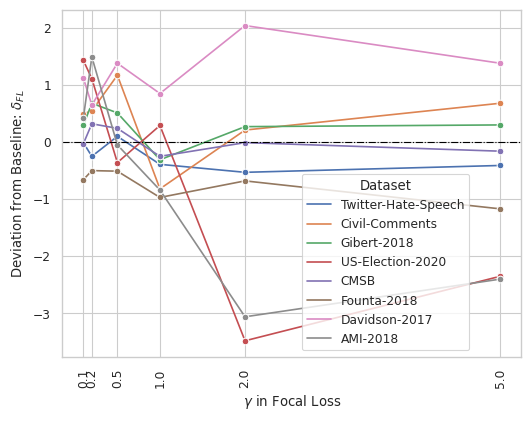

In [39]:
data_no_clear_fl = ["us-election-2020", "cmsb-tsd", "founta-2018-thas"]
which_data_to_check = (((df_all_mean_results["variant"] == "fl"))
                        # & (~df_all_mean_results["data_name"].isin(data_no_clear_fl))
                        )
df_mean_fl = df_all_mean_results[which_data_to_check][["data_name", "fl_gamma", "val_f1_macro"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "val_f1_macro"].values[0]
    return row['val_f1_macro'] - baseline_value
df_mean_fl["val_f1_macro_delta"] = df_mean_fl.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)
df_mean_fl = df_mean_fl.rename({"data_name":"Dataset"}, axis=1)

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5.4,4.3))
sns.lineplot(x="fl_gamma", y="val_f1_macro_delta", data=df_mean_fl, hue="Dataset", marker="o", ax=ax)
gamma_ticks = df_mean_fl.fl_gamma.unique().tolist()
ax.set_xticks(gamma_ticks, labels=gamma_ticks, rotation=90)
ax.set_xlabel(r"$\gamma$ in Focal Loss")
# # delta_ticks = [y for y in list(range(-2, 8, 2))]
# # ax.set_yticks(delta_ticks)

ax.set_ylabel(r"Deviation from Baseline: $\delta_{FL}$")
# # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
sns.move_legend(ax, "lower right", bbox_to_anchor=(.9, 0.)) #
ax.figure.tight_layout()
ax.figure.savefig('results/FL_trend.svg', dpi=600, bbox_inches="tight")

#### Why are some data not good in FL?

In [24]:
# check if unpromising results in fl is because the negative class was improved
data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_not_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
338,us-election-2020,0.1,81.92,74.44,99.82,98.72,95.56,68.28,94.48,54.40
339,us-election-2020,0.2,81.60,77.82,99.57,96.91,96.08,67.11,95.76,59.87
340,us-election-2020,0.5,80.13,72.89,99.66,97.57,95.77,64.49,95.11,50.67
341,us-election-2020,1.0,80.78,73.88,99.64,97.46,95.08,66.48,94.28,53.48
342,us-election-2020,2.0,77.01,74.45,99.20,94.01,95.57,58.46,95.79,53.10
343,us-election-2020,5.0,78.14,72.41,99.21,94.24,95.01,61.27,94.82,50.00
495,waseem-and-hovy-2016,0.1,86.53,86.77,99.41,98.36,92.94,80.11,93.22,80.32
496,waseem-and-hovy-2016,0.2,86.44,86.95,99.39,98.31,92.87,80.02,93.23,80.68
497,waseem-and-hovy-2016,0.5,86.16,86.50,99.33,98.16,92.46,79.85,92.75,80.25
498,waseem-and-hovy-2016,1.0,86.08,86.69,99.37,98.25,92.82,79.34,93.19,80.19


In [30]:
# check if unpromising results in fl is because the negative class was improved
data_good_in_fl = ["founta-2018-thas", "ami"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", "train_f1_per_label_2", "train_f1_per_label_3", "train_f1_per_label_4",
                    "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3", "val_f1_per_label_4",
                    "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,train_f1_per_label_2,train_f1_per_label_3,train_f1_per_label_4,val_f1_per_label_0,val_f1_per_label_1,val_f1_per_label_2,val_f1_per_label_3,val_f1_per_label_4,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
572,founta-2018-thas,0.1,62.30,62.92,98.47,94.16,96.66,91.46,0.00,86.55,52.49,76.89,33.27,0.00,86.39,52.00,78.56,34.73,0.00
573,founta-2018-thas,0.2,62.46,63.55,98.01,92.48,95.58,88.16,0.00,86.22,54.31,77.37,31.95,0.00,86.21,53.43,78.32,36.22,0.00
574,founta-2018-thas,0.5,62.45,62.91,97.77,91.49,95.39,87.83,0.00,86.98,53.22,77.90,31.70,0.00,86.91,52.85,78.85,33.02,0.00
575,founta-2018-thas,1.0,61.99,63.18,96.95,88.46,94.13,84.39,0.00,86.65,54.80,76.77,29.75,0.00,86.86,55.06,77.53,33.29,0.00
576,founta-2018-thas,2.0,62.28,62.93,97.24,89.33,95.27,88.20,0.00,86.54,53.85,76.73,32.00,0.00,86.54,53.50,77.19,34.47,0.00
577,founta-2018-thas,5.0,61.79,62.60,94.38,78.25,91.91,78.17,0.00,84.84,54.97,75.51,31.84,0.00,85.11,55.08,75.57,34.66,0.00
708,ami,0.1,52.93,54.25,99.56,97.64,95.85,98.99,97.56,75.64,45.58,35.45,54.40,53.60,65.13,85.09,45.69,52.34,23.02
709,ami,0.2,54.00,56.44,99.58,98.63,96.51,99.37,97.81,76.50,47.97,33.89,52.37,59.28,67.06,84.39,48.82,57.32,24.63
710,ami,0.5,52.46,54.92,99.72,99.25,98.64,99.50,100.00,76.90,48.44,35.76,51.19,50.02,65.48,85.64,46.06,55.99,21.42
711,ami,1.0,51.67,54.10,99.72,99.13,98.18,99.24,100.00,77.12,47.95,35.19,50.88,47.21,65.83,84.61,41.61,53.95,24.52


### Weighted Focal Loss

In [99]:
conditions = (df_all_mean_results["variant"] == "wfl")
df_mean_wfl = df_all_mean_results[conditions][["data_name", "wce_alpha", "fl_gamma", "val_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)
df_mean_wfl

,data_name,wce_alpha,fl_gamma,test_f1_macro
70,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.1,62.87
71,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.2,63.24
72,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",0.5,64.22
73,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",1.0,63.14
74,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",2.0,64.07
75,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",5.0,62.32
76,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.1,60.43
77,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.2,59.90
78,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",0.5,60.03
79,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",1.0,57.76


### Augmentation

In [45]:
conditions = (df_all_mean_results["variant"] == "augmentation_bert")
# data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "augmentation_rho", "augmentation_percentage", "augmentation_top_k", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_bert = df_all_mean_results[conditions][relevant_cols]
# df_mean_aug["data_name"] = df_mean_aug["data_name"].map(data_name_orig2display)
df_mean_aug_bert

,data_name,augmentation_rho,augmentation_percentage,augmentation_top_k,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
0,bretschneider-th-main,1.5,0.1,3,77.28,69.22,97.92,97.00,96.31,58.25,94.82,43.62
1,bretschneider-th-main,1.5,0.1,5,78.15,70.57,97.99,97.11,96.87,59.42,95.35,45.79
2,bretschneider-th-main,1.5,0.3,3,74.98,65.85,97.81,96.79,95.93,54.03,93.94,37.77
3,bretschneider-th-main,1.5,0.3,5,73.44,65.99,97.68,96.62,95.82,51.06,94.29,37.69
4,bretschneider-th-main,2.0,0.1,3,76.76,69.05,97.98,96.16,96.25,57.27,94.65,43.45
...,...,...,...,...,...,...,...,...,...,...,...,...
713,ami,1.5,0.3,5,52.00,51.71,99.43,99.77,76.90,44.16,65.26,84.02
714,ami,3.0,0.1,3,53.15,54.62,99.15,99.74,78.75,41.66,66.38,82.02
715,ami,3.0,0.1,5,51.48,55.38,99.30,99.34,77.20,42.07,65.98,83.82
716,ami,3.0,0.3,3,51.20,51.68,99.39,99.34,77.68,43.04,62.22,82.47


In [54]:
df_all_mean_results[df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"])]

,data_name,num_classes,data_type,size,rho,distribution,variant,sampling_modifiedRS_rho,sampling_weightedRS_percentage,augmentation_rho,...,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4,test_accuracy,test_precision_macro,test_precision_weighted,test_recall_macro,test_recall_weighted,test_auprc
8,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.0,...,30.14,0.00,0.00,0.00,87.59,59.97,91.28,66.51,87.59,58.47
9,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.2,...,35.22,0.00,0.00,0.00,88.68,62.13,91.96,70.03,88.68,60.35
10,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.5,...,31.51,0.00,0.00,0.00,87.36,60.05,91.48,68.06,87.36,59.16
18,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.0,-,-,...,49.94,0.00,0.00,0.00,92.41,70.18,93.72,77.06,92.41,67.06
19,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.2,-,-,...,47.78,0.00,0.00,0.00,92.59,70.11,93.36,74.21,92.59,66.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,1.5,-,-,...,86.69,42.01,49.83,25.82,64.13,59.05,68.73,55.57,64.13,56.60
728,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,2.0,-,-,...,76.84,44.50,55.69,31.75,61.88,62.39,68.23,55.29,61.88,56.59
729,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,3.0,-,-,...,84.46,45.08,55.18,28.04,65.07,58.58,67.51,57.03,65.07,57.98
730,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,5.0,-,-,...,82.67,46.23,56.15,26.08,64.35,59.20,67.42,55.95,64.35,57.43


In [75]:
data_to_check = data_names[:-1]
conditions = (df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"]) 
                & df_all_mean_results["data_name"].isin(data_to_check))
relevant_cols = ["data_name", "variant", "sampling_modifiedRS_rho", "augmentation_rho", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_ext = df_all_mean_results[conditions][relevant_cols]
def get_rho(row):
    if row["sampling_modifiedRS_rho"] != "-":
        return row["sampling_modifiedRS_rho"]
    if row["augmentation_rho"] != "-":
        return row["augmentation_rho"]
df_mean_aug_ext["rho"] = df_mean_aug_ext.apply(lambda row: get_rho(row), axis=1)
df_mean_aug_ext["data_name"] = df_mean_aug_ext["data_name"].map(data_name_orig2display)
df_mean_aug_ext = df_mean_aug_ext[["data_name", "variant", "rho"] + relevant_cols[4:]]
df_mean_aug_ext = df_mean_aug_ext.sort_values(by=['data_name', 'rho']).reset_index(drop=True)
df_mean_aug_ext.to_csv("check_external_data.csv", index=False)

## Check MLflow runs

In [ ]:
mlrun_ids = []

with open("./outputs/ami_augmentation_abusive_lexicon_seed0_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

# with open("./outputs/twitter-hate-speech-tsa_sampling_weightedRS_oversampling_seed21_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/ami_augmentation_abusive_lexicon_seed42_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]
    
# with open("./outputs/ami/ami_augmentation_bert_seed0_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

for id in mlrun_ids:
    print(id)

len(mlrun_ids)

In [1]:
ignored_ids = []
import os
data_runs_dir = f'./mlruns/8'
run_ids = os.listdir(data_runs_dir)
logs = dict()
for run_id in run_ids:
    if run_id not in ignored_ids:
        ckpt_dir = f"{data_runs_dir}/{run_id}/artifacts/model_checkpoints/"
        try:
            ckpt = os.listdir(ckpt_dir)[0]
            # if "fl" in ckpt:
                # # print(f"{run_id}")
            # if "external" in ckpt:
                # for root, _, files in os.walk(f"{data_runs_dir}/{run_id}"):
                #     key = "augmentation_rho"
                #     if key in files:
                #         with open(f"{root}/{key}", "r") as f:
                #             value = f.readlines()[-1]
                #             if value == "1.0":
                #                 print(f"{run_id}\t{ckpt}")
                            # print(f"{key} = {value}")
            #             key = "augmentation_percentage"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "0.5":
            #                         print(run_id)
            #             key = "augmentation_bert_top_k"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "1":
            #                         print(run_id)
            print(f"{run_id}")
            logs[run_id] = ckpt
        except NotADirectoryError:
            pass
# print(logs)
len(logs)

2728fe0eb3ae428d85017f9494616295
8efe7986aeeb4c559141e0550fbd475f
4a6c69e0cf074d20b3f5b58f58241358
df954233e5d04cc2acc506f3f3907863
f103f351edf5483094cb6784d6ac7bb4
ece865ba0beb4b8b87f3acefe895cf30
ce0f4541a5824466a47505a79693e156
0e5519abfd974401b4aa7fa2b5e810de
c152a080d93541eea9d47e1b66edc957
d4b8b76ea092464782d6c851b6cf14b5
5edd3c47ee1045d7ad1eaeef416cbef9
34cd6355538e4c079c73f8ac9210b3bb
7225739f144b48d59abff7af4c0accfe
a26b958aed064324965f9ce7a8a588f4
4da8dd63afa74af5b49c2757dd118910


15